In [1]:
import pandas as pd

df = pd.read_csv('../Dataset/FeatureEngineering_T2M_data.csv')
df.tail()

,date,tsoil1,tsoil2,tsoil3,tsoil4,t2m,t2m_max,t2m_min,t10m,t10m_max,...,t2m_volatility_3d_lag3,t2m_anomaly_lag1,t2m_anomaly_lag2,t2m_anomaly_lag3,temp_gradient_surface_lag1,temp_gradient_surface_lag2,temp_gradient_surface_lag3,wind_chill_factor_lag1,wind_chill_factor_lag2,wind_chill_factor_lag3
16360,2025-11-06,25.73,25.71,26.11,26.56,26.15,29.52,23.51,26.16,29.34,...,0.030380,-0.707586,-0.637586,-0.217586,-1.00,-0.82,-0.65,25.716,25.754,26.090
16361,2025-11-07,25.82,25.99,26.12,26.53,26.40,27.92,24.67,26.55,27.90,...,0.036043,-0.027586,-0.707586,-0.637586,-0.85,-1.00,-0.82,26.396,25.716,25.754
16362,2025-11-08,26.35,26.09,26.14,26.51,27.16,29.76,25.52,27.35,29.63,...,0.010329,0.222414,-0.027586,-0.707586,-0.26,-0.85,-1.00,26.639,26.396,25.716
16363,2025-11-09,27.01,26.53,26.25,26.50,27.78,30.85,25.51,28.00,30.76,...,0.014542,0.982414,0.222414,-0.027586,-0.18,-0.26,-0.85,27.039,26.639,26.396
16364,2025-11-10,27.22,26.89,26.45,26.50,27.96,30.47,26.15,28.21,30.25,...,0.018506,1.602414,0.982414,0.222414,-0.38,-0.18,-0.26,27.609,27.039,26.639


In [2]:
len(df.columns)

399

### X, y and Train / Test for Time Series

In [3]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

In [4]:
H = 7
t2m_targets = [f"t2m_d{h}_forecast" for h in range(1, H+1)]

In [5]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

feature_cols = [c for c in num_cols if c not in t2m_targets]

print("Number of features:", len(feature_cols))
print("Targets:", t2m_targets)

Number of features: 391
Targets: ['t2m_d1_forecast', 't2m_d2_forecast', 't2m_d3_forecast', 't2m_d4_forecast', 't2m_d5_forecast', 't2m_d6_forecast', 't2m_d7_forecast']


In [6]:
X = df[feature_cols]         # shape = (n_samples, n_features)
Y = df[t2m_targets]           # shape = (n_samples, 7)

In [7]:
test_ratio = 0.2
n_samples = len(df)
split_idx = int(n_samples * (1 - test_ratio))

# split
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
Y_train, Y_test = Y.iloc[:split_idx], Y.iloc[split_idx:]

print("Train size:", X_train.shape, Y_train.shape)
print("Test  size:", X_test.shape, Y_test.shape)

Train size: (13092, 391) (13092, 7)
Test  size: (3273, 391) (3273, 7)


### Train LightGBM (Multi-Output)

In [8]:
%pip install lightgbm optuna tqdm

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


### feature importance

In [9]:
from lightgbm import LGBMRegressor

t2m_last_col = Y_train.columns[-1]

fs_model = LGBMRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=-1,
    num_leaves=63,
    random_state=42,
    n_jobs=-1
)

fs_model.fit(X_train, Y_train[t2m_last_col])

# ดึง feature importance
importances = pd.Series(fs_model.feature_importances_, index=X_train.columns)
importances = importances.sort_values(ascending=False)

# เลือก top-k features
TOP_K = 200  
selected_features = importances.head(TOP_K).index.tolist()

print(f"Selected top {TOP_K} features from LightGBM importance:")
print(selected_features)

X_train_fs = X_train[selected_features].copy()
X_test_fs  = X_test[selected_features].copy()

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022778 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87208
[LightGBM] [Info] Number of data points in the train set: 13092, number of used features: 391
[LightGBM] [Info] Start training from score 27.835404
Selected top 200 features from LightGBM importance:
['month_progress', 'dayofyear', 'doy_sin', 'tsoil4_roll7_std', 'gwettop_roll7_std', 'tsoil3_roll7_std', 't2m_trend_strength', 'ts_max_roll7_std', 'to3', 'rhoa_roll7_std', 'rhoa_roll3_std', 'tsoil4_lag7', 'gwettop_roll3_std', 'doy_cos', 'tsoil4_roll3_std', 'ts_min_roll7_std', 't10m_min_roll7_std', 'tsoil4', 'to3_lag7', 't10m_max_roll7_std', 'gwetprof_roll7_std', 'to3_lag3', 'to3_lag5', 'v2m_roll7_std', 't2m_anomaly_lag3', 't2m_rolling_iqr', 'v50m_roll7_std', 'tsoil2_roll7_std', 't2mwet_roll7_std', 't2m_anomaly', 'gwetroot_roll7_std', 'to3_lag4', 'to3_lag6', 'tsoil3_lag7', 'ts_min_roll3_std', 'to3_

In [10]:
import optuna
from lightgbm import LGBMRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import cross_val_score
from tqdm.auto import tqdm

# Create validation split for optuna
val_ratio = 0.2
val_split_idx = int(len(X_train_fs) * (1 - val_ratio))

X_train_opt = X_train_fs.iloc[:val_split_idx]
Y_train_opt = Y_train.iloc[:val_split_idx]
X_val_opt   = X_train_fs.iloc[val_split_idx:]
Y_val_opt   = Y_train.iloc[val_split_idx:]

print("Optuna train size:", X_train_opt.shape, Y_train_opt.shape)
print("Optuna val   size:", X_val_opt.shape,   Y_val_opt.shape)

def objective(trial):
    # Suggest hyperparameters
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'num_leaves': trial.suggest_int('num_leaves', 20, 200),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'objective': 'regression',
        'random_state': 42,
        'n_jobs': -1,
        'verbose': -1  # suppress warnings
    }
    
    # Create model
    base_lgbm = LGBMRegressor(**params)
    model = MultiOutputRegressor(base_lgbm)
    
    # Train on training data
    model.fit(X_train_opt, Y_train_opt)
    
    # Predict on validation data
    Y_pred_val = model.predict(X_val_opt)
    
    # Calculate RMSE (objective to minimize)
    rmse = sqrt(mean_squared_error(Y_val_opt, Y_pred_val))
    
    return rmse

# Run Optuna optimization with built-in progress bar
study = optuna.create_study(direction='minimize', 
                           study_name='lgbm_t2m_forecast',
                           sampler=optuna.samplers.TPESampler(seed=42))

study.optimize(objective, 
               n_trials=100,
               timeout=1800,  # 30 นาที timeout
               show_progress_bar=True)

# Print best results
print(f"Best RMSE: {study.best_value:.4f}")
print(f"Best parameters:")
for key, value in study.best_params.items():
    print(f"   {key}: {value}")

# Train final model with best parameters
best_params = study.best_params
best_params.update({
    'objective': 'regression',
    'random_state': 42,
    'n_jobs': -1,
    'verbose': -1
})

c:\Users\09350\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-11-24 19:32:58,082] A new study created in memory with name: lgbm_t2m_forecast


Optuna train size: (10473, 200) (10473, 7)
Optuna val   size: (2619, 200) (2619, 7)


Best trial: 0. Best value: 1.22321:   1%|          | 1/100 [00:23<38:40, 23.44s/it, 23.44/1800 seconds]

[I 2025-11-24 19:33:21,524] Trial 0 finished with value: 1.2232099726276968 and parameters: {'n_estimators': 437, 'learning_rate': 0.2536999076681772, 'max_depth': 12, 'num_leaves': 128, 'subsample': 0.6624074561769746, 'colsample_bytree': 0.662397808134481, 'reg_alpha': 3.3323645788192616e-08, 'reg_lambda': 0.6245760287469893, 'min_child_samples': 62}. Best is trial 0 with value: 1.2232099726276968.


Best trial: 1. Best value: 1.15898:   2%|▏         | 2/100 [01:18<1:08:21, 41.85s/it, 78.18/1800 seconds]

[I 2025-11-24 19:34:16,260] Trial 1 finished with value: 1.1589770205546803 and parameters: {'n_estimators': 737, 'learning_rate': 0.010725209743171996, 'max_depth': 15, 'num_leaves': 170, 'subsample': 0.6849356442713105, 'colsample_bytree': 0.6727299868828402, 'reg_alpha': 4.4734294104626844e-07, 'reg_lambda': 5.472429642032198e-06, 'min_child_samples': 55}. Best is trial 1 with value: 1.1589770205546803.


Best trial: 2. Best value: 1.15041:   3%|▎         | 3/100 [01:44<56:10, 34.75s/it, 104.47/1800 seconds] 

[I 2025-11-24 19:34:42,557] Trial 2 finished with value: 1.1504135804323528 and parameters: {'n_estimators': 489, 'learning_rate': 0.02692655251486473, 'max_depth': 10, 'num_leaves': 45, 'subsample': 0.7168578594140873, 'colsample_bytree': 0.7465447373174767, 'reg_alpha': 0.00012724181576752517, 'reg_lambda': 0.1165691561324743, 'min_child_samples': 24}. Best is trial 2 with value: 1.1504135804323528.


Best trial: 3. Best value: 1.14052:   4%|▍         | 4/100 [01:50<37:23, 23.37s/it, 110.41/1800 seconds]

[I 2025-11-24 19:34:48,495] Trial 3 finished with value: 1.1405202503973468 and parameters: {'n_estimators': 563, 'learning_rate': 0.07500118950416987, 'max_depth': 3, 'num_leaves': 129, 'subsample': 0.6682096494749166, 'colsample_bytree': 0.6260206371941118, 'reg_alpha': 3.4671276804481113, 'reg_lambda': 4.905556676028774, 'min_child_samples': 82}. Best is trial 3 with value: 1.1405202503973468.


Best trial: 3. Best value: 1.14052:   5%|▌         | 5/100 [02:33<48:28, 30.61s/it, 153.86/1800 seconds]

[I 2025-11-24 19:35:31,945] Trial 4 finished with value: 1.149737981372654 and parameters: {'n_estimators': 374, 'learning_rate': 0.013940346079873234, 'max_depth': 11, 'num_leaves': 99, 'subsample': 0.6488152939379115, 'colsample_bytree': 0.798070764044508, 'reg_alpha': 2.039373116525212e-08, 'reg_lambda': 1.527156759251193, 'min_child_samples': 29}. Best is trial 3 with value: 1.1405202503973468.


Best trial: 3. Best value: 1.14052:   6%|▌         | 6/100 [03:04<47:42, 30.46s/it, 184.01/1800 seconds]

[I 2025-11-24 19:36:02,096] Trial 5 finished with value: 1.1592607195532898 and parameters: {'n_estimators': 696, 'learning_rate': 0.028869220380495747, 'max_depth': 9, 'num_leaves': 118, 'subsample': 0.6739417822102108, 'colsample_bytree': 0.9878338511058234, 'reg_alpha': 0.09466630153726856, 'reg_lambda': 2.854239907497756, 'min_child_samples': 90}. Best is trial 3 with value: 1.1405202503973468.


Best trial: 3. Best value: 1.14052:   7%|▋         | 7/100 [03:13<36:22, 23.47s/it, 193.09/1800 seconds]

[I 2025-11-24 19:36:11,177] Trial 6 finished with value: 1.2039083004508653 and parameters: {'n_estimators': 638, 'learning_rate': 0.22999586428143728, 'max_depth': 4, 'num_leaves': 55, 'subsample': 0.6180909155642152, 'colsample_bytree': 0.7301321323053057, 'reg_alpha': 3.148441347423712e-05, 'reg_lambda': 2.7678419414850017e-06, 'min_child_samples': 84}. Best is trial 3 with value: 1.1405202503973468.


Best trial: 3. Best value: 1.14052:   8%|▊         | 8/100 [03:31<33:17, 21.71s/it, 211.03/1800 seconds]

[I 2025-11-24 19:36:29,114] Trial 7 finished with value: 1.1416140959384469 and parameters: {'n_estimators': 421, 'learning_rate': 0.026000059117302653, 'max_depth': 10, 'num_leaves': 45, 'subsample': 0.9208787923016158, 'colsample_bytree': 0.6298202574719083, 'reg_alpha': 7.620481786158549, 'reg_lambda': 0.08916674715636537, 'min_child_samples': 24}. Best is trial 3 with value: 1.1405202503973468.


Best trial: 3. Best value: 1.14052:   9%|▉         | 9/100 [03:36<25:07, 16.57s/it, 216.30/1800 seconds]

[I 2025-11-24 19:36:34,385] Trial 8 finished with value: 1.1792670289670848 and parameters: {'n_estimators': 104, 'learning_rate': 0.1601531217136121, 'max_depth': 12, 'num_leaves': 151, 'subsample': 0.9085081386743783, 'colsample_bytree': 0.6296178606936361, 'reg_alpha': 1.683416412018213e-05, 'reg_lambda': 1.1036250149900698e-07, 'min_child_samples': 87}. Best is trial 3 with value: 1.1405202503973468.


Best trial: 9. Best value: 1.12996:  10%|█         | 10/100 [03:43<20:42, 13.81s/it, 223.92/1800 seconds]

[I 2025-11-24 19:36:42,008] Trial 9 finished with value: 1.1299580223473586 and parameters: {'n_estimators': 661, 'learning_rate': 0.030816017044468066, 'max_depth': 3, 'num_leaves': 76, 'subsample': 0.7300733288106989, 'colsample_bytree': 0.8918424713352255, 'reg_alpha': 0.005470376807480391, 'reg_lambda': 0.9658611176861268, 'min_child_samples': 50}. Best is trial 9 with value: 1.1299580223473586.


Best trial: 9. Best value: 1.12996:  11%|█         | 11/100 [04:14<27:59, 18.87s/it, 254.26/1800 seconds]

[I 2025-11-24 19:37:12,346] Trial 10 finished with value: 1.1771639375531346 and parameters: {'n_estimators': 962, 'learning_rate': 0.07457153485515941, 'max_depth': 6, 'num_leaves': 82, 'subsample': 0.8010124870699186, 'colsample_bytree': 0.9407901565064135, 'reg_alpha': 0.00775155271689379, 'reg_lambda': 0.0037022205646195516, 'min_child_samples': 40}. Best is trial 9 with value: 1.1299580223473586.


Best trial: 9. Best value: 1.12996:  12%|█▏        | 12/100 [04:24<23:58, 16.34s/it, 264.83/1800 seconds]

[I 2025-11-24 19:37:22,916] Trial 11 finished with value: 1.152908020571662 and parameters: {'n_estimators': 861, 'learning_rate': 0.07078016263700229, 'max_depth': 3, 'num_leaves': 82, 'subsample': 0.7737425087025644, 'colsample_bytree': 0.8920339412764792, 'reg_alpha': 3.981991595504633, 'reg_lambda': 0.0029151336209232823, 'min_child_samples': 67}. Best is trial 9 with value: 1.1299580223473586.


Best trial: 9. Best value: 1.12996:  13%|█▎        | 13/100 [04:36<21:39, 14.94s/it, 276.54/1800 seconds]

[I 2025-11-24 19:37:34,628] Trial 12 finished with value: 1.141280377435595 and parameters: {'n_estimators': 240, 'learning_rate': 0.04739343434296961, 'max_depth': 6, 'num_leaves': 200, 'subsample': 0.7668689715046754, 'colsample_bytree': 0.8610724800899923, 'reg_alpha': 0.020439174832648923, 'reg_lambda': 8.16904021802771, 'min_child_samples': 8}. Best is trial 9 with value: 1.1299580223473586.


Best trial: 9. Best value: 1.12996:  14%|█▍        | 14/100 [04:51<21:18, 14.87s/it, 291.25/1800 seconds]

[I 2025-11-24 19:37:49,336] Trial 13 finished with value: 1.1752500676972553 and parameters: {'n_estimators': 598, 'learning_rate': 0.09154387249271213, 'max_depth': 6, 'num_leaves': 21, 'subsample': 0.8213350815835946, 'colsample_bytree': 0.8476671509616371, 'reg_alpha': 0.439749014504107, 'reg_lambda': 0.015633838004575174, 'min_child_samples': 73}. Best is trial 9 with value: 1.1299580223473586.


Best trial: 9. Best value: 1.12996:  15%|█▌        | 15/100 [05:00<18:30, 13.06s/it, 300.13/1800 seconds]

[I 2025-11-24 19:37:58,212] Trial 14 finished with value: 1.1404867636453555 and parameters: {'n_estimators': 803, 'learning_rate': 0.04316562549151683, 'max_depth': 3, 'num_leaves': 136, 'subsample': 0.7282654921905216, 'colsample_bytree': 0.8056239626685042, 'reg_alpha': 0.0014086715444086308, 'reg_lambda': 0.0001279792581265537, 'min_child_samples': 42}. Best is trial 9 with value: 1.1299580223473586.


Best trial: 9. Best value: 1.12996:  16%|█▌        | 16/100 [05:17<20:01, 14.31s/it, 317.32/1800 seconds]

[I 2025-11-24 19:38:15,402] Trial 15 finished with value: 1.159240073206421 and parameters: {'n_estimators': 819, 'learning_rate': 0.04123019909391433, 'max_depth': 5, 'num_leaves': 152, 'subsample': 0.8561711433906496, 'colsample_bytree': 0.8147779460590779, 'reg_alpha': 0.000930483688788521, 'reg_lambda': 2.4619153699084035e-05, 'min_child_samples': 45}. Best is trial 9 with value: 1.1299580223473586.


Best trial: 9. Best value: 1.12996:  17%|█▋        | 17/100 [06:07<34:40, 25.07s/it, 367.43/1800 seconds]

[I 2025-11-24 19:39:05,513] Trial 16 finished with value: 1.1583609598216686 and parameters: {'n_estimators': 953, 'learning_rate': 0.016308355406652878, 'max_depth': 8, 'num_leaves': 90, 'subsample': 0.7311941285873849, 'colsample_bytree': 0.9189851877998994, 'reg_alpha': 0.0013701243085454573, 'reg_lambda': 9.02860554581942e-05, 'min_child_samples': 39}. Best is trial 9 with value: 1.1299580223473586.


Best trial: 9. Best value: 1.12996:  18%|█▊        | 18/100 [06:35<35:21, 25.88s/it, 395.18/1800 seconds]

[I 2025-11-24 19:39:33,260] Trial 17 finished with value: 1.1568662576481006 and parameters: {'n_estimators': 800, 'learning_rate': 0.020286758687412355, 'max_depth': 7, 'num_leaves': 71, 'subsample': 0.8597523289555756, 'colsample_bytree': 0.7731031903848434, 'reg_alpha': 3.199160813819233e-06, 'reg_lambda': 2.1219899323605756e-08, 'min_child_samples': 52}. Best is trial 9 with value: 1.1299580223473586.


Best trial: 9. Best value: 1.12996:  19%|█▉        | 19/100 [06:49<30:05, 22.29s/it, 409.10/1800 seconds]

[I 2025-11-24 19:39:47,185] Trial 18 finished with value: 1.1539491037517768 and parameters: {'n_estimators': 693, 'learning_rate': 0.038378564808131045, 'max_depth': 4, 'num_leaves': 109, 'subsample': 0.7474202038063273, 'colsample_bytree': 0.9884002606432983, 'reg_alpha': 0.007515571723249142, 'reg_lambda': 0.00022163473160045528, 'min_child_samples': 11}. Best is trial 9 with value: 1.1299580223473586.


Best trial: 9. Best value: 1.12996:  20%|██        | 20/100 [06:59<24:45, 18.57s/it, 419.00/1800 seconds]

[I 2025-11-24 19:39:57,083] Trial 19 finished with value: 1.1881690578436088 and parameters: {'n_estimators': 880, 'learning_rate': 0.14168046193643366, 'max_depth': 3, 'num_leaves': 150, 'subsample': 0.7043810986542952, 'colsample_bytree': 0.8493617190974246, 'reg_alpha': 0.00030468089368308873, 'reg_lambda': 0.001083723495633459, 'min_child_samples': 32}. Best is trial 9 with value: 1.1299580223473586.


Best trial: 9. Best value: 1.12996:  21%|██        | 21/100 [07:41<34:03, 25.86s/it, 461.88/1800 seconds]

[I 2025-11-24 19:40:39,963] Trial 20 finished with value: 1.1846036068616892 and parameters: {'n_estimators': 774, 'learning_rate': 0.058194115192875484, 'max_depth': 15, 'num_leaves': 189, 'subsample': 0.9793245210155404, 'colsample_bytree': 0.9370278606745907, 'reg_alpha': 0.18992081864118202, 'reg_lambda': 8.331477971522001e-07, 'min_child_samples': 100}. Best is trial 9 with value: 1.1299580223473586.


Best trial: 9. Best value: 1.12996:  22%|██▏       | 22/100 [07:48<25:57, 19.96s/it, 468.07/1800 seconds]

[I 2025-11-24 19:40:46,159] Trial 21 finished with value: 1.1525961737973784 and parameters: {'n_estimators': 561, 'learning_rate': 0.10262523980364094, 'max_depth': 3, 'num_leaves': 134, 'subsample': 0.6006677825307941, 'colsample_bytree': 0.7065916059622793, 'reg_alpha': 0.036857067984580785, 'reg_lambda': 0.08238299403473216, 'min_child_samples': 76}. Best is trial 9 with value: 1.1299580223473586.


Best trial: 9. Best value: 1.12996:  23%|██▎       | 23/100 [07:56<21:21, 16.64s/it, 476.98/1800 seconds]

[I 2025-11-24 19:40:55,062] Trial 22 finished with value: 1.135010126217977 and parameters: {'n_estimators': 518, 'learning_rate': 0.03483827904963353, 'max_depth': 4, 'num_leaves': 133, 'subsample': 0.6376704813322893, 'colsample_bytree': 0.8166274989979831, 'reg_alpha': 0.3930085119423106, 'reg_lambda': 9.489175007246127, 'min_child_samples': 55}. Best is trial 9 with value: 1.1299580223473586.


Best trial: 9. Best value: 1.12996:  24%|██▍       | 24/100 [08:05<17:51, 14.10s/it, 485.13/1800 seconds]

[I 2025-11-24 19:41:03,213] Trial 23 finished with value: 1.1341264453743258 and parameters: {'n_estimators': 322, 'learning_rate': 0.032872988618029675, 'max_depth': 5, 'num_leaves': 110, 'subsample': 0.6328132216300938, 'colsample_bytree': 0.8119271356076697, 'reg_alpha': 0.5481928049399266, 'reg_lambda': 0.21549895303348388, 'min_child_samples': 52}. Best is trial 9 with value: 1.1299580223473586.


Best trial: 9. Best value: 1.12996:  25%|██▌       | 25/100 [08:13<15:20, 12.27s/it, 493.13/1800 seconds]

[I 2025-11-24 19:41:11,215] Trial 24 finished with value: 1.13376712158949 and parameters: {'n_estimators': 291, 'learning_rate': 0.032179994845864125, 'max_depth': 5, 'num_leaves': 106, 'subsample': 0.6266588870817675, 'colsample_bytree': 0.8847421637350066, 'reg_alpha': 0.8919679547618734, 'reg_lambda': 0.4749967389989878, 'min_child_samples': 55}. Best is trial 9 with value: 1.1299580223473586.


Best trial: 25. Best value: 1.12464:  26%|██▌       | 26/100 [08:21<13:48, 11.20s/it, 501.85/1800 seconds]

[I 2025-11-24 19:41:19,930] Trial 25 finished with value: 1.1246449719461797 and parameters: {'n_estimators': 275, 'learning_rate': 0.021324316845310182, 'max_depth': 5, 'num_leaves': 65, 'subsample': 0.6296597063466071, 'colsample_bytree': 0.8935946012806082, 'reg_alpha': 1.2506529291140647, 'reg_lambda': 0.3973726831333605, 'min_child_samples': 50}. Best is trial 25 with value: 1.1246449719461797.


Best trial: 25. Best value: 1.12464:  27%|██▋       | 27/100 [08:33<13:54, 11.44s/it, 513.83/1800 seconds]

[I 2025-11-24 19:41:31,920] Trial 26 finished with value: 1.1370174797734944 and parameters: {'n_estimators': 208, 'learning_rate': 0.019900896880638872, 'max_depth': 7, 'num_leaves': 62, 'subsample': 0.6918316037561212, 'colsample_bytree': 0.8847420880324552, 'reg_alpha': 2.51860150091865, 'reg_lambda': 0.022769974758756542, 'min_child_samples': 64}. Best is trial 25 with value: 1.1246449719461797.


Best trial: 25. Best value: 1.12464:  28%|██▊       | 28/100 [08:42<12:44, 10.62s/it, 522.55/1800 seconds]

[I 2025-11-24 19:41:40,636] Trial 27 finished with value: 1.1268001322353267 and parameters: {'n_estimators': 278, 'learning_rate': 0.02227109899047471, 'max_depth': 5, 'num_leaves': 23, 'subsample': 0.6002079737940916, 'colsample_bytree': 0.9550092915485743, 'reg_alpha': 0.773836691159826, 'reg_lambda': 1.0435884153077384, 'min_child_samples': 47}. Best is trial 25 with value: 1.1246449719461797.


Best trial: 25. Best value: 1.12464:  29%|██▉       | 29/100 [08:47<10:43,  9.06s/it, 527.99/1800 seconds]

[I 2025-11-24 19:41:46,071] Trial 28 finished with value: 1.2472610359063248 and parameters: {'n_estimators': 112, 'learning_rate': 0.010250861222669298, 'max_depth': 7, 'num_leaves': 21, 'subsample': 0.6096425400052035, 'colsample_bytree': 0.9585951186817028, 'reg_alpha': 0.09753217435982936, 'reg_lambda': 0.02174380157676721, 'min_child_samples': 34}. Best is trial 25 with value: 1.1246449719461797.


Best trial: 25. Best value: 1.12464:  30%|███       | 30/100 [08:58<11:10,  9.58s/it, 538.75/1800 seconds]

[I 2025-11-24 19:41:56,837] Trial 29 finished with value: 1.1328692993646452 and parameters: {'n_estimators': 187, 'learning_rate': 0.0196122070503045, 'max_depth': 13, 'num_leaves': 37, 'subsample': 0.6507356494416001, 'colsample_bytree': 0.9118990925162718, 'reg_alpha': 0.007590694297555829, 'reg_lambda': 0.8408429953645732, 'min_child_samples': 47}. Best is trial 25 with value: 1.1246449719461797.


Best trial: 25. Best value: 1.12464:  31%|███       | 31/100 [09:26<17:15, 15.00s/it, 566.42/1800 seconds]

[I 2025-11-24 19:42:24,504] Trial 30 finished with value: 1.1470048159562225 and parameters: {'n_estimators': 456, 'learning_rate': 0.014818179251976512, 'max_depth': 8, 'num_leaves': 68, 'subsample': 0.6012817148473876, 'colsample_bytree': 0.9658753157254673, 'reg_alpha': 1.2822835644335808e-07, 'reg_lambda': 0.6038044478073898, 'min_child_samples': 62}. Best is trial 25 with value: 1.1246449719461797.


Best trial: 25. Best value: 1.12464:  32%|███▏      | 32/100 [09:37<15:33, 13.72s/it, 577.15/1800 seconds]

[I 2025-11-24 19:42:35,233] Trial 31 finished with value: 1.1314167731741918 and parameters: {'n_estimators': 192, 'learning_rate': 0.021247423983156568, 'max_depth': 13, 'num_leaves': 34, 'subsample': 0.6548767491354586, 'colsample_bytree': 0.9088972106033041, 'reg_alpha': 0.008547233294041844, 'reg_lambda': 1.2135937742852805, 'min_child_samples': 47}. Best is trial 25 with value: 1.1246449719461797.


Best trial: 25. Best value: 1.12464:  33%|███▎      | 33/100 [09:51<15:25, 13.82s/it, 591.19/1800 seconds]

[I 2025-11-24 19:42:49,269] Trial 32 finished with value: 1.1390781257399893 and parameters: {'n_estimators': 288, 'learning_rate': 0.02298668033568568, 'max_depth': 13, 'num_leaves': 33, 'subsample': 0.6712450048746275, 'colsample_bytree': 0.9181568483867476, 'reg_alpha': 0.031670226139725186, 'reg_lambda': 1.0499048665777053, 'min_child_samples': 48}. Best is trial 25 with value: 1.1246449719461797.


Best trial: 25. Best value: 1.12464:  34%|███▍      | 34/100 [10:02<14:23, 13.08s/it, 602.56/1800 seconds]

[I 2025-11-24 19:43:00,642] Trial 33 finished with value: 1.1438726475527223 and parameters: {'n_estimators': 169, 'learning_rate': 0.014004681679349798, 'max_depth': 13, 'num_leaves': 53, 'subsample': 0.6954966905635311, 'colsample_bytree': 0.8698827820270185, 'reg_alpha': 1.1875473244703425, 'reg_lambda': 0.2065489402076621, 'min_child_samples': 58}. Best is trial 25 with value: 1.1246449719461797.


Best trial: 25. Best value: 1.12464:  35%|███▌      | 35/100 [10:09<12:16, 11.34s/it, 609.82/1800 seconds]

[I 2025-11-24 19:43:07,903] Trial 34 finished with value: 1.12653037113475 and parameters: {'n_estimators': 368, 'learning_rate': 0.02435559607096938, 'max_depth': 4, 'num_leaves': 32, 'subsample': 0.6593405972200249, 'colsample_bytree': 0.9551961317212392, 'reg_alpha': 0.003357542301863906, 'reg_lambda': 1.9993956247918097, 'min_child_samples': 35}. Best is trial 25 with value: 1.1246449719461797.


Best trial: 25. Best value: 1.12464:  36%|███▌      | 36/100 [10:17<10:52, 10.19s/it, 617.34/1800 seconds]

[I 2025-11-24 19:43:15,422] Trial 35 finished with value: 1.1288830630399749 and parameters: {'n_estimators': 372, 'learning_rate': 0.026928151105105734, 'max_depth': 4, 'num_leaves': 44, 'subsample': 0.6853173688911619, 'colsample_bytree': 0.9993950803628516, 'reg_alpha': 3.378051156868259e-05, 'reg_lambda': 3.1961507854352353, 'min_child_samples': 33}. Best is trial 25 with value: 1.1246449719461797.


Best trial: 25. Best value: 1.12464:  37%|███▋      | 37/100 [10:30<11:47, 11.23s/it, 630.98/1800 seconds]

[I 2025-11-24 19:43:29,067] Trial 36 finished with value: 1.1247356731647316 and parameters: {'n_estimators': 378, 'learning_rate': 0.011923397940987806, 'max_depth': 5, 'num_leaves': 44, 'subsample': 0.6653194056957803, 'colsample_bytree': 0.9997410283121413, 'reg_alpha': 5.71248181506667e-05, 'reg_lambda': 2.8652847069517224, 'min_child_samples': 21}. Best is trial 25 with value: 1.1246449719461797.


Best trial: 25. Best value: 1.12464:  38%|███▊      | 38/100 [10:44<12:19, 11.92s/it, 644.53/1800 seconds]

[I 2025-11-24 19:43:42,609] Trial 37 finished with value: 1.1253399608351777 and parameters: {'n_estimators': 388, 'learning_rate': 0.011345640022478641, 'max_depth': 5, 'num_leaves': 28, 'subsample': 0.6513737700091045, 'colsample_bytree': 0.9678220054517275, 'reg_alpha': 1.524440361684085e-06, 'reg_lambda': 0.06112163551847533, 'min_child_samples': 18}. Best is trial 25 with value: 1.1246449719461797.


Best trial: 25. Best value: 1.12464:  39%|███▉      | 39/100 [11:03<14:15, 14.03s/it, 663.48/1800 seconds]

[I 2025-11-24 19:44:01,559] Trial 38 finished with value: 1.1338773518295437 and parameters: {'n_estimators': 349, 'learning_rate': 0.01216838383354908, 'max_depth': 6, 'num_leaves': 54, 'subsample': 0.6519086089384939, 'colsample_bytree': 0.9759637488121091, 'reg_alpha': 1.5003626258495024e-06, 'reg_lambda': 0.041771967077967515, 'min_child_samples': 20}. Best is trial 25 with value: 1.1246449719461797.


Best trial: 25. Best value: 1.12464:  40%|████      | 40/100 [11:23<15:44, 15.74s/it, 683.21/1800 seconds]

[I 2025-11-24 19:44:21,295] Trial 39 finished with value: 1.1330211743655842 and parameters: {'n_estimators': 419, 'learning_rate': 0.01202690882439453, 'max_depth': 8, 'num_leaves': 31, 'subsample': 0.7109437076627604, 'colsample_bytree': 0.9477762406083594, 'reg_alpha': 6.37062864527084e-08, 'reg_lambda': 0.004737682563724459, 'min_child_samples': 17}. Best is trial 25 with value: 1.1246449719461797.


Best trial: 25. Best value: 1.12464:  41%|████      | 41/100 [11:37<15:07, 15.37s/it, 697.72/1800 seconds]

[I 2025-11-24 19:44:35,808] Trial 40 finished with value: 1.1347603184426889 and parameters: {'n_estimators': 485, 'learning_rate': 0.016382429417955296, 'max_depth': 5, 'num_leaves': 59, 'subsample': 0.6639627506191326, 'colsample_bytree': 0.9769349281177486, 'reg_alpha': 8.313502809005845e-06, 'reg_lambda': 0.27566406193655296, 'min_child_samples': 26}. Best is trial 25 with value: 1.1246449719461797.


Best trial: 41. Best value: 1.12065:  42%|████▏     | 42/100 [11:47<13:13, 13.67s/it, 707.43/1800 seconds]

[I 2025-11-24 19:44:45,515] Trial 41 finished with value: 1.1206543323915097 and parameters: {'n_estimators': 257, 'learning_rate': 0.012037044998824704, 'max_depth': 5, 'num_leaves': 44, 'subsample': 0.6219303217754745, 'colsample_bytree': 0.9387654258833027, 'reg_alpha': 0.0001561711762963508, 'reg_lambda': 3.1556102683837035, 'min_child_samples': 15}. Best is trial 41 with value: 1.1206543323915097.


Best trial: 42. Best value: 1.11591:  43%|████▎     | 43/100 [11:57<11:54, 12.53s/it, 717.29/1800 seconds]

[I 2025-11-24 19:44:55,375] Trial 42 finished with value: 1.1159085319371755 and parameters: {'n_estimators': 408, 'learning_rate': 0.012075720755752627, 'max_depth': 4, 'num_leaves': 44, 'subsample': 0.6314206456478262, 'colsample_bytree': 0.9274943162958517, 'reg_alpha': 0.0001461577739683802, 'reg_lambda': 3.1107663640299035, 'min_child_samples': 14}. Best is trial 42 with value: 1.1159085319371755.


Best trial: 42. Best value: 1.11591:  44%|████▍     | 44/100 [12:18<14:08, 15.15s/it, 738.55/1800 seconds]

[I 2025-11-24 19:45:16,634] Trial 43 finished with value: 1.1327464964851406 and parameters: {'n_estimators': 439, 'learning_rate': 0.012112336573355864, 'max_depth': 6, 'num_leaves': 46, 'subsample': 0.6305746125581296, 'colsample_bytree': 0.932646134169428, 'reg_alpha': 0.00011844092557740346, 'reg_lambda': 3.3415988312803853, 'min_child_samples': 14}. Best is trial 42 with value: 1.1159085319371755.


Best trial: 42. Best value: 1.11591:  45%|████▌     | 45/100 [12:33<13:57, 15.24s/it, 753.99/1800 seconds]

[I 2025-11-24 19:45:32,076] Trial 44 finished with value: 1.121613709112267 and parameters: {'n_estimators': 403, 'learning_rate': 0.01014377132653968, 'max_depth': 5, 'num_leaves': 43, 'subsample': 0.6182094266011492, 'colsample_bytree': 0.9999240187082451, 'reg_alpha': 6.573036079206602e-05, 'reg_lambda': 5.0285438193017535, 'min_child_samples': 5}. Best is trial 42 with value: 1.1159085319371755.


Best trial: 45. Best value: 1.11357:  46%|████▌     | 46/100 [12:40<11:23, 12.65s/it, 760.61/1800 seconds]

[I 2025-11-24 19:45:38,689] Trial 45 finished with value: 1.113566623535641 and parameters: {'n_estimators': 250, 'learning_rate': 0.01699495035098197, 'max_depth': 4, 'num_leaves': 44, 'subsample': 0.6247279407917402, 'colsample_bytree': 0.9938773253039377, 'reg_alpha': 9.228810123032189e-05, 'reg_lambda': 4.793784808103636, 'min_child_samples': 5}. Best is trial 45 with value: 1.113566623535641.


Best trial: 46. Best value: 1.11228:  47%|████▋     | 47/100 [12:46<09:23, 10.63s/it, 766.52/1800 seconds]

[I 2025-11-24 19:45:44,605] Trial 46 finished with value: 1.112277814519849 and parameters: {'n_estimators': 245, 'learning_rate': 0.017139853009215427, 'max_depth': 4, 'num_leaves': 65, 'subsample': 0.6227381271827769, 'colsample_bytree': 0.9279825669899552, 'reg_alpha': 0.0002806716800941718, 'reg_lambda': 6.093044003168989, 'min_child_samples': 5}. Best is trial 46 with value: 1.112277814519849.


Best trial: 46. Best value: 1.11228:  48%|████▊     | 48/100 [12:50<07:30,  8.67s/it, 770.60/1800 seconds]

[I 2025-11-24 19:45:48,685] Trial 47 finished with value: 1.1275808751994452 and parameters: {'n_estimators': 143, 'learning_rate': 0.01603141331537835, 'max_depth': 4, 'num_leaves': 51, 'subsample': 0.6223814692455072, 'colsample_bytree': 0.9333050494575332, 'reg_alpha': 0.0002971090922146644, 'reg_lambda': 9.254331757314283, 'min_child_samples': 7}. Best is trial 46 with value: 1.112277814519849.


Best trial: 46. Best value: 1.11228:  49%|████▉     | 49/100 [12:54<06:14,  7.33s/it, 774.83/1800 seconds]

[I 2025-11-24 19:45:52,914] Trial 48 finished with value: 1.1221113832286969 and parameters: {'n_estimators': 240, 'learning_rate': 0.010194266735547927, 'max_depth': 3, 'num_leaves': 87, 'subsample': 0.612881018543844, 'colsample_bytree': 0.9830267981036778, 'reg_alpha': 1.3253156919404247e-05, 'reg_lambda': 5.766725629216997, 'min_child_samples': 5}. Best is trial 46 with value: 1.112277814519849.


Best trial: 46. Best value: 1.11228:  50%|█████     | 50/100 [13:01<06:04,  7.28s/it, 781.99/1800 seconds]

[I 2025-11-24 19:46:00,077] Trial 49 finished with value: 1.118729722073345 and parameters: {'n_estimators': 323, 'learning_rate': 0.017595218327962205, 'max_depth': 4, 'num_leaves': 40, 'subsample': 0.6783556740639862, 'colsample_bytree': 0.9215124665867973, 'reg_alpha': 0.00013295502738945423, 'reg_lambda': 4.094781866699297, 'min_child_samples': 12}. Best is trial 46 with value: 1.112277814519849.


Best trial: 46. Best value: 1.11228:  51%|█████     | 51/100 [13:06<05:18,  6.50s/it, 786.66/1800 seconds]

[I 2025-11-24 19:46:04,747] Trial 50 finished with value: 1.112719868623264 and parameters: {'n_estimators': 238, 'learning_rate': 0.017918334709596976, 'max_depth': 4, 'num_leaves': 78, 'subsample': 0.6383627845643055, 'colsample_bytree': 0.6645998162328414, 'reg_alpha': 0.0007238443473056482, 'reg_lambda': 0.12461907296243714, 'min_child_samples': 12}. Best is trial 46 with value: 1.112277814519849.


Best trial: 51. Best value: 1.11052:  52%|█████▏    | 52/100 [13:11<04:43,  5.91s/it, 791.19/1800 seconds]

[I 2025-11-24 19:46:09,275] Trial 51 finished with value: 1.110515031839496 and parameters: {'n_estimators': 240, 'learning_rate': 0.017832968876215802, 'max_depth': 4, 'num_leaves': 74, 'subsample': 0.6780098973109527, 'colsample_bytree': 0.6083515092873013, 'reg_alpha': 0.0006170795429884365, 'reg_lambda': 1.6672294118127844, 'min_child_samples': 12}. Best is trial 51 with value: 1.110515031839496.


Best trial: 51. Best value: 1.11052:  53%|█████▎    | 53/100 [13:17<04:36,  5.88s/it, 797.01/1800 seconds]

[I 2025-11-24 19:46:15,089] Trial 52 finished with value: 1.1187186330288592 and parameters: {'n_estimators': 328, 'learning_rate': 0.018441932949698956, 'max_depth': 4, 'num_leaves': 74, 'subsample': 0.6800592991867749, 'colsample_bytree': 0.6530265089399152, 'reg_alpha': 0.0009008110967102095, 'reg_lambda': 0.14443777147742068, 'min_child_samples': 12}. Best is trial 51 with value: 1.110515031839496.


Best trial: 53. Best value: 1.10548:  54%|█████▍    | 54/100 [13:20<03:52,  5.05s/it, 800.12/1800 seconds]

[I 2025-11-24 19:46:18,201] Trial 53 finished with value: 1.10548432422526 and parameters: {'n_estimators': 229, 'learning_rate': 0.01424688509982282, 'max_depth': 3, 'num_leaves': 98, 'subsample': 0.6458373987100038, 'colsample_bytree': 0.609782147493132, 'reg_alpha': 0.0007093561449575894, 'reg_lambda': 0.009241364488603486, 'min_child_samples': 10}. Best is trial 53 with value: 1.10548432422526.


Best trial: 53. Best value: 1.10548:  55%|█████▌    | 55/100 [13:23<03:19,  4.44s/it, 803.13/1800 seconds]

[I 2025-11-24 19:46:21,211] Trial 54 finished with value: 1.1056883700069342 and parameters: {'n_estimators': 222, 'learning_rate': 0.013874637444911292, 'max_depth': 3, 'num_leaves': 95, 'subsample': 0.6478166354133881, 'colsample_bytree': 0.6167128328141888, 'reg_alpha': 0.0006215007667181325, 'reg_lambda': 0.0013074419875389231, 'min_child_samples': 24}. Best is trial 53 with value: 1.10548432422526.


Best trial: 55. Best value: 1.10545:  56%|█████▌    | 56/100 [13:26<02:56,  4.00s/it, 806.12/1800 seconds]

[I 2025-11-24 19:46:24,201] Trial 55 finished with value: 1.1054475803832584 and parameters: {'n_estimators': 218, 'learning_rate': 0.014108988934369321, 'max_depth': 3, 'num_leaves': 97, 'subsample': 0.6471739413390581, 'colsample_bytree': 0.6008696032286583, 'reg_alpha': 0.0007095713903463569, 'reg_lambda': 0.0012928395906563147, 'min_child_samples': 10}. Best is trial 55 with value: 1.1054475803832584.


Best trial: 56. Best value: 1.10536:  57%|█████▋    | 57/100 [13:29<02:40,  3.74s/it, 809.25/1800 seconds]

[I 2025-11-24 19:46:27,337] Trial 56 finished with value: 1.1053556096530783 and parameters: {'n_estimators': 217, 'learning_rate': 0.014673353251382191, 'max_depth': 3, 'num_leaves': 98, 'subsample': 0.7510369673665467, 'colsample_bytree': 0.6063925047911378, 'reg_alpha': 0.0005688797845486573, 'reg_lambda': 0.0008744673188407911, 'min_child_samples': 25}. Best is trial 56 with value: 1.1053556096530783.


Best trial: 56. Best value: 1.10536:  58%|█████▊    | 58/100 [13:31<02:17,  3.28s/it, 811.46/1800 seconds]

[I 2025-11-24 19:46:29,540] Trial 57 finished with value: 1.1437202530684842 and parameters: {'n_estimators': 132, 'learning_rate': 0.014497426608861505, 'max_depth': 3, 'num_leaves': 97, 'subsample': 0.7606207531185916, 'colsample_bytree': 0.6056470054581535, 'reg_alpha': 0.002507810528553099, 'reg_lambda': 0.0006811264079594191, 'min_child_samples': 25}. Best is trial 56 with value: 1.1053556096530783.


Best trial: 56. Best value: 1.10536:  59%|█████▉    | 59/100 [13:34<02:10,  3.18s/it, 814.40/1800 seconds]

[I 2025-11-24 19:46:32,486] Trial 58 finished with value: 1.108096447131445 and parameters: {'n_estimators': 214, 'learning_rate': 0.013407155773157346, 'max_depth': 3, 'num_leaves': 123, 'subsample': 0.7938629980441392, 'colsample_bytree': 0.605178597565195, 'reg_alpha': 0.0005090093712582128, 'reg_lambda': 4.315538229173106e-05, 'min_child_samples': 9}. Best is trial 56 with value: 1.1053556096530783.


Best trial: 56. Best value: 1.10536:  60%|██████    | 60/100 [13:36<01:58,  2.96s/it, 816.84/1800 seconds]

[I 2025-11-24 19:46:34,926] Trial 59 finished with value: 1.1287857183894712 and parameters: {'n_estimators': 159, 'learning_rate': 0.01365002297582474, 'max_depth': 3, 'num_leaves': 120, 'subsample': 0.795367526383641, 'colsample_bytree': 0.6062646217201587, 'reg_alpha': 0.0004429379865804718, 'reg_lambda': 3.8624502341099824e-05, 'min_child_samples': 29}. Best is trial 56 with value: 1.1053556096530783.


Best trial: 56. Best value: 1.10536:  61%|██████    | 61/100 [13:39<01:52,  2.88s/it, 819.54/1800 seconds]

[I 2025-11-24 19:46:37,621] Trial 60 finished with value: 1.16449287465588 and parameters: {'n_estimators': 218, 'learning_rate': 0.23236780145825367, 'max_depth': 3, 'num_leaves': 99, 'subsample': 0.8182577735684676, 'colsample_bytree': 0.6414542871583768, 'reg_alpha': 0.0027345730077772946, 'reg_lambda': 6.9002832226018535e-06, 'min_child_samples': 23}. Best is trial 56 with value: 1.1053556096530783.


Best trial: 56. Best value: 1.10536:  62%|██████▏   | 62/100 [13:42<01:51,  2.95s/it, 822.64/1800 seconds]

[I 2025-11-24 19:46:40,726] Trial 61 finished with value: 1.109359662667152 and parameters: {'n_estimators': 212, 'learning_rate': 0.013475250803191032, 'max_depth': 3, 'num_leaves': 92, 'subsample': 0.7865024092712195, 'colsample_bytree': 0.6847074230803266, 'reg_alpha': 0.00043424576077102136, 'reg_lambda': 0.0009175332741032816, 'min_child_samples': 9}. Best is trial 56 with value: 1.1053556096530783.


Best trial: 56. Best value: 1.10536:  63%|██████▎   | 63/100 [13:45<01:49,  2.97s/it, 825.67/1800 seconds]

[I 2025-11-24 19:46:43,759] Trial 62 finished with value: 1.1126513087176853 and parameters: {'n_estimators': 200, 'learning_rate': 0.01331673000636219, 'max_depth': 3, 'num_leaves': 118, 'subsample': 0.7887837075337194, 'colsample_bytree': 0.691212553854535, 'reg_alpha': 0.0017954655894587925, 'reg_lambda': 0.0017771479382298757, 'min_child_samples': 10}. Best is trial 56 with value: 1.1053556096530783.


Best trial: 56. Best value: 1.10536:  64%|██████▍   | 64/100 [13:48<01:41,  2.83s/it, 828.16/1800 seconds]

[I 2025-11-24 19:46:46,241] Trial 63 finished with value: 1.1151180612724039 and parameters: {'n_estimators': 164, 'learning_rate': 0.0153469376373863, 'max_depth': 3, 'num_leaves': 92, 'subsample': 0.8494494548516771, 'colsample_bytree': 0.6181244215637147, 'reg_alpha': 0.0005864408632370116, 'reg_lambda': 0.00889357131702652, 'min_child_samples': 18}. Best is trial 56 with value: 1.1053556096530783.


Best trial: 56. Best value: 1.10536:  65%|██████▌   | 65/100 [13:50<01:29,  2.57s/it, 830.13/1800 seconds]

[I 2025-11-24 19:46:48,211] Trial 64 finished with value: 1.2090226197620628 and parameters: {'n_estimators': 100, 'learning_rate': 0.013601536859936328, 'max_depth': 3, 'num_leaves': 104, 'subsample': 0.7480522948357378, 'colsample_bytree': 0.621038225367579, 'reg_alpha': 0.0011965569144033734, 'reg_lambda': 0.0004120713966746303, 'min_child_samples': 9}. Best is trial 56 with value: 1.1053556096530783.


Best trial: 56. Best value: 1.10536:  66%|██████▌   | 66/100 [13:53<01:34,  2.78s/it, 833.39/1800 seconds]

[I 2025-11-24 19:46:51,472] Trial 65 finished with value: 1.1872539179303605 and parameters: {'n_estimators': 299, 'learning_rate': 0.29866373378393074, 'max_depth': 3, 'num_leaves': 115, 'subsample': 0.7800371542189131, 'colsample_bytree': 0.6363782683457474, 'reg_alpha': 3.0340059946260566e-05, 'reg_lambda': 0.00015388521379538662, 'min_child_samples': 28}. Best is trial 56 with value: 1.1053556096530783.


Best trial: 66. Best value: 1.10506:  67%|██████▋   | 67/100 [13:56<01:32,  2.81s/it, 836.28/1800 seconds]

[I 2025-11-24 19:46:54,362] Trial 66 finished with value: 1.1050557998511943 and parameters: {'n_estimators': 210, 'learning_rate': 0.014984595839040701, 'max_depth': 3, 'num_leaves': 83, 'subsample': 0.8130388939127878, 'colsample_bytree': 0.6010182664386915, 'reg_alpha': 0.016080420455050527, 'reg_lambda': 4.122096579346717e-05, 'min_child_samples': 21}. Best is trial 66 with value: 1.1050557998511943.


Best trial: 66. Best value: 1.10506:  68%|██████▊   | 68/100 [14:08<02:57,  5.56s/it, 848.24/1800 seconds]

[I 2025-11-24 19:47:06,325] Trial 67 finished with value: 1.1610964608173915 and parameters: {'n_estimators': 135, 'learning_rate': 0.01515827171624769, 'max_depth': 11, 'num_leaves': 82, 'subsample': 0.8152234090284971, 'colsample_bytree': 0.6506664983858718, 'reg_alpha': 0.02160115127701175, 'reg_lambda': 4.3856049772988304e-05, 'min_child_samples': 22}. Best is trial 66 with value: 1.1050557998511943.


Best trial: 66. Best value: 1.10506:  69%|██████▉   | 69/100 [14:11<02:28,  4.78s/it, 851.20/1800 seconds]

[I 2025-11-24 19:47:09,280] Trial 68 finished with value: 1.1061399982916833 and parameters: {'n_estimators': 196, 'learning_rate': 0.02576505676967785, 'max_depth': 3, 'num_leaves': 93, 'subsample': 0.8058130768963478, 'colsample_bytree': 0.7367712664131, 'reg_alpha': 0.01314949187237357, 'reg_lambda': 1.3232358231493446e-05, 'min_child_samples': 16}. Best is trial 66 with value: 1.1050557998511943.


Best trial: 69. Best value: 1.10422:  70%|███████   | 70/100 [14:13<02:05,  4.18s/it, 853.98/1800 seconds]

[I 2025-11-24 19:47:12,061] Trial 69 finished with value: 1.1042158984197716 and parameters: {'n_estimators': 174, 'learning_rate': 0.025268301638225667, 'max_depth': 3, 'num_leaves': 103, 'subsample': 0.8804076832662993, 'colsample_bytree': 0.7379092267082521, 'reg_alpha': 0.016835264470226492, 'reg_lambda': 1.022748071491339e-05, 'min_child_samples': 16}. Best is trial 69 with value: 1.1042158984197716.


Best trial: 69. Best value: 1.10422:  71%|███████   | 71/100 [14:16<01:48,  3.75s/it, 856.72/1800 seconds]

[I 2025-11-24 19:47:14,799] Trial 70 finished with value: 1.1050731158959182 and parameters: {'n_estimators': 178, 'learning_rate': 0.027428461367684433, 'max_depth': 3, 'num_leaves': 85, 'subsample': 0.9223779626656008, 'colsample_bytree': 0.7401644371145772, 'reg_alpha': 0.05470448923130702, 'reg_lambda': 9.290442991928995e-06, 'min_child_samples': 16}. Best is trial 69 with value: 1.1042158984197716.


Best trial: 69. Best value: 1.10422:  72%|███████▏  | 72/100 [14:19<01:37,  3.47s/it, 859.55/1800 seconds]

[I 2025-11-24 19:47:17,639] Trial 71 finished with value: 1.1066103158476746 and parameters: {'n_estimators': 178, 'learning_rate': 0.028926543656109253, 'max_depth': 3, 'num_leaves': 102, 'subsample': 0.9225516241822007, 'colsample_bytree': 0.7594630415954814, 'reg_alpha': 0.07438504374463038, 'reg_lambda': 8.066540274417112e-06, 'min_child_samples': 16}. Best is trial 69 with value: 1.1042158984197716.


Best trial: 69. Best value: 1.10422:  73%|███████▎  | 73/100 [14:21<01:23,  3.11s/it, 861.81/1800 seconds]

[I 2025-11-24 19:47:19,897] Trial 72 finished with value: 1.1078443195291647 and parameters: {'n_estimators': 123, 'learning_rate': 0.024436650556313815, 'max_depth': 3, 'num_leaves': 87, 'subsample': 0.8998724272856078, 'colsample_bytree': 0.7295388869510862, 'reg_alpha': 0.011998734289914145, 'reg_lambda': 6.222484934457458e-07, 'min_child_samples': 20}. Best is trial 69 with value: 1.1042158984197716.


Best trial: 69. Best value: 1.10422:  74%|███████▍  | 74/100 [14:24<01:15,  2.91s/it, 864.27/1800 seconds]

[I 2025-11-24 19:47:22,356] Trial 73 finished with value: 1.113953560891724 and parameters: {'n_estimators': 150, 'learning_rate': 0.05406713847276039, 'max_depth': 3, 'num_leaves': 111, 'subsample': 0.9505906869179513, 'colsample_bytree': 0.7872443330370104, 'reg_alpha': 0.06545674900316029, 'reg_lambda': 2.029793815960389e-06, 'min_child_samples': 26}. Best is trial 69 with value: 1.1042158984197716.


Best trial: 69. Best value: 1.10422:  75%|███████▌  | 75/100 [14:29<01:30,  3.61s/it, 869.52/1800 seconds]

[I 2025-11-24 19:47:27,599] Trial 74 finished with value: 1.1213843109167958 and parameters: {'n_estimators': 270, 'learning_rate': 0.026366401365057846, 'max_depth': 4, 'num_leaves': 95, 'subsample': 0.8794908262777177, 'colsample_bytree': 0.7273049537183234, 'reg_alpha': 0.24209778072730798, 'reg_lambda': 2.307570722754617e-05, 'min_child_samples': 19}. Best is trial 69 with value: 1.1042158984197716.


Best trial: 69. Best value: 1.10422:  76%|███████▌  | 76/100 [14:33<01:29,  3.73s/it, 873.53/1800 seconds]

[I 2025-11-24 19:47:31,611] Trial 75 finished with value: 1.111077338379795 and parameters: {'n_estimators': 183, 'learning_rate': 0.019610349833353045, 'max_depth': 4, 'num_leaves': 84, 'subsample': 0.833707574510172, 'colsample_bytree': 0.7088251056474215, 'reg_alpha': 0.005286775235410301, 'reg_lambda': 1.2672109026977142e-05, 'min_child_samples': 23}. Best is trial 69 with value: 1.1042158984197716.


Best trial: 69. Best value: 1.10422:  77%|███████▋  | 77/100 [15:00<04:05, 10.65s/it, 900.33/1800 seconds]

[I 2025-11-24 19:47:58,412] Trial 76 finished with value: 1.1727662238771137 and parameters: {'n_estimators': 600, 'learning_rate': 0.046688780928994464, 'max_depth': 9, 'num_leaves': 108, 'subsample': 0.8867861449664836, 'colsample_bytree': 0.6274535402485303, 'reg_alpha': 0.03908227958688837, 'reg_lambda': 0.00037429973511681185, 'min_child_samples': 36}. Best is trial 69 with value: 1.1042158984197716.


Best trial: 69. Best value: 1.10422:  78%|███████▊  | 78/100 [15:03<03:02,  8.30s/it, 903.13/1800 seconds]

[I 2025-11-24 19:48:01,216] Trial 77 finished with value: 1.1085841122646372 and parameters: {'n_estimators': 215, 'learning_rate': 0.03491767384310307, 'max_depth': 3, 'num_leaves': 101, 'subsample': 0.9563538003453087, 'colsample_bytree': 0.6159925108792986, 'reg_alpha': 0.012153262145773842, 'reg_lambda': 2.751511897952627e-06, 'min_child_samples': 30}. Best is trial 69 with value: 1.1042158984197716.


Best trial: 69. Best value: 1.10422:  79%|███████▉  | 79/100 [15:13<03:05,  8.84s/it, 913.23/1800 seconds]

[I 2025-11-24 19:48:11,316] Trial 78 finished with value: 1.1415336962147733 and parameters: {'n_estimators': 998, 'learning_rate': 0.028961177576908435, 'max_depth': 3, 'num_leaves': 114, 'subsample': 0.9397601109522166, 'colsample_bytree': 0.7513281390380278, 'reg_alpha': 0.0038389400237089383, 'reg_lambda': 7.601631615098564e-05, 'min_child_samples': 17}. Best is trial 69 with value: 1.1042158984197716.


Best trial: 69. Best value: 1.10422:  80%|████████  | 80/100 [15:17<02:29,  7.46s/it, 917.49/1800 seconds]

[I 2025-11-24 19:48:15,570] Trial 79 finished with value: 1.1141424184388424 and parameters: {'n_estimators': 180, 'learning_rate': 0.02299689973133772, 'max_depth': 4, 'num_leaves': 80, 'subsample': 0.8070332561733402, 'colsample_bytree': 0.8292431338670262, 'reg_alpha': 0.017462380041794533, 'reg_lambda': 0.002441621737295092, 'min_child_samples': 27}. Best is trial 69 with value: 1.1042158984197716.


Best trial: 69. Best value: 1.10422:  81%|████████  | 81/100 [15:21<02:00,  6.34s/it, 921.20/1800 seconds]

[I 2025-11-24 19:48:19,285] Trial 80 finished with value: 1.1051275098955295 and parameters: {'n_estimators': 310, 'learning_rate': 0.010943975906797044, 'max_depth': 3, 'num_leaves': 95, 'subsample': 0.8301695190440086, 'colsample_bytree': 0.6779067502623538, 'reg_alpha': 0.005604472213692174, 'reg_lambda': 0.00843440220551657, 'min_child_samples': 15}. Best is trial 69 with value: 1.1042158984197716.


Best trial: 69. Best value: 1.10422:  82%|████████▏ | 82/100 [15:24<01:39,  5.51s/it, 924.78/1800 seconds]

[I 2025-11-24 19:48:22,863] Trial 81 finished with value: 1.1054908015673954 and parameters: {'n_estimators': 285, 'learning_rate': 0.011111206344357843, 'max_depth': 3, 'num_leaves': 95, 'subsample': 0.83758080071191, 'colsample_bytree': 0.6724958388461664, 'reg_alpha': 0.005765517832302218, 'reg_lambda': 0.0065529374137945, 'min_child_samples': 15}. Best is trial 69 with value: 1.1042158984197716.


Best trial: 69. Best value: 1.10422:  83%|████████▎ | 83/100 [15:29<01:27,  5.15s/it, 929.08/1800 seconds]

[I 2025-11-24 19:48:27,168] Trial 82 finished with value: 1.105291267055141 and parameters: {'n_estimators': 313, 'learning_rate': 0.010916953705750927, 'max_depth': 3, 'num_leaves': 88, 'subsample': 0.8440030305424441, 'colsample_bytree': 0.6768859616938866, 'reg_alpha': 0.14959889567653312, 'reg_lambda': 0.007099888706382944, 'min_child_samples': 14}. Best is trial 69 with value: 1.1042158984197716.


Best trial: 69. Best value: 1.10422:  84%|████████▍ | 84/100 [15:58<03:21, 12.57s/it, 958.96/1800 seconds]

[I 2025-11-24 19:48:57,045] Trial 83 finished with value: 1.1436105647137402 and parameters: {'n_estimators': 302, 'learning_rate': 0.011134300863283821, 'max_depth': 15, 'num_leaves': 87, 'subsample': 0.8360940930698817, 'colsample_bytree': 0.6779255509436779, 'reg_alpha': 0.13443341915753093, 'reg_lambda': 0.009143678777562527, 'min_child_samples': 14}. Best is trial 69 with value: 1.1042158984197716.


Best trial: 69. Best value: 1.10422:  85%|████████▌ | 85/100 [16:06<02:45, 11.03s/it, 966.42/1800 seconds]

[I 2025-11-24 19:49:04,501] Trial 84 finished with value: 1.1102969654394397 and parameters: {'n_estimators': 355, 'learning_rate': 0.010362373961474939, 'max_depth': 4, 'num_leaves': 126, 'subsample': 0.8746797221050786, 'colsample_bytree': 0.701118026176794, 'reg_alpha': 0.04634862564955771, 'reg_lambda': 0.007993475789723873, 'min_child_samples': 21}. Best is trial 69 with value: 1.1042158984197716.


Best trial: 69. Best value: 1.10422:  86%|████████▌ | 86/100 [16:10<02:03,  8.82s/it, 970.08/1800 seconds]

[I 2025-11-24 19:49:08,163] Trial 85 finished with value: 1.1079175125064673 and parameters: {'n_estimators': 264, 'learning_rate': 0.011211819617301414, 'max_depth': 3, 'num_leaves': 103, 'subsample': 0.8632977541089197, 'colsample_bytree': 0.6661223325546071, 'reg_alpha': 0.026694954891173968, 'reg_lambda': 0.0038575716222867657, 'min_child_samples': 7}. Best is trial 69 with value: 1.1042158984197716.


Best trial: 69. Best value: 1.10422:  87%|████████▋ | 87/100 [16:16<01:44,  8.04s/it, 976.30/1800 seconds]

[I 2025-11-24 19:49:14,387] Trial 86 finished with value: 1.1112281430297735 and parameters: {'n_estimators': 311, 'learning_rate': 0.012587846008778401, 'max_depth': 4, 'num_leaves': 89, 'subsample': 0.8360994047749907, 'colsample_bytree': 0.6516046098947414, 'reg_alpha': 1.0185267139205113e-08, 'reg_lambda': 0.033301269709383394, 'min_child_samples': 14}. Best is trial 69 with value: 1.1042158984197716.


Best trial: 69. Best value: 1.10422:  88%|████████▊ | 88/100 [16:52<03:16, 16.41s/it, 1012.24/1800 seconds]

[I 2025-11-24 19:49:50,322] Trial 87 finished with value: 1.1432463962972148 and parameters: {'n_estimators': 336, 'learning_rate': 0.011036319982903529, 'max_depth': 14, 'num_leaves': 98, 'subsample': 0.843139576017164, 'colsample_bytree': 0.6391810935289531, 'reg_alpha': 0.2528162553664435, 'reg_lambda': 0.012512517987658603, 'min_child_samples': 11}. Best is trial 69 with value: 1.1042158984197716.


Best trial: 69. Best value: 1.10422:  89%|████████▉ | 89/100 [16:56<02:19, 12.67s/it, 1016.19/1800 seconds]

[I 2025-11-24 19:49:54,279] Trial 88 finished with value: 1.104315209787592 and parameters: {'n_estimators': 283, 'learning_rate': 0.015281196019187078, 'max_depth': 3, 'num_leaves': 70, 'subsample': 0.8259660679657482, 'colsample_bytree': 0.6747873281975851, 'reg_alpha': 0.004517625071749597, 'reg_lambda': 0.00020754154939107855, 'min_child_samples': 19}. Best is trial 69 with value: 1.1042158984197716.


Best trial: 69. Best value: 1.10422:  90%|█████████ | 90/100 [17:00<01:42, 10.22s/it, 1020.70/1800 seconds]

[I 2025-11-24 19:49:58,788] Trial 89 finished with value: 1.1152024894048196 and parameters: {'n_estimators': 271, 'learning_rate': 0.019345126062950958, 'max_depth': 4, 'num_leaves': 69, 'subsample': 0.8245089372246375, 'colsample_bytree': 0.7180534220292245, 'reg_alpha': 0.002054683119097161, 'reg_lambda': 0.00019039317830751225, 'min_child_samples': 19}. Best is trial 69 with value: 1.1042158984197716.


Best trial: 69. Best value: 1.10422:  91%|█████████ | 91/100 [17:06<01:21,  9.04s/it, 1026.98/1800 seconds]

[I 2025-11-24 19:50:05,064] Trial 90 finished with value: 1.1202553591324724 and parameters: {'n_estimators': 230, 'learning_rate': 0.015551425456476944, 'max_depth': 5, 'num_leaves': 76, 'subsample': 0.8653321761420145, 'colsample_bytree': 0.6923884245674635, 'reg_alpha': 0.004446580279644966, 'reg_lambda': 0.0006146669310863988, 'min_child_samples': 31}. Best is trial 69 with value: 1.1042158984197716.


Best trial: 91. Best value: 1.10377:  92%|█████████▏| 92/100 [17:10<00:58,  7.34s/it, 1030.36/1800 seconds]

[I 2025-11-24 19:50:08,441] Trial 91 finished with value: 1.1037738286588044 and parameters: {'n_estimators': 284, 'learning_rate': 0.01270566674507645, 'max_depth': 3, 'num_leaves': 107, 'subsample': 0.9019985117742184, 'colsample_bytree': 0.6761138560841368, 'reg_alpha': 0.008481051241108322, 'reg_lambda': 0.005616342590912549, 'min_child_samples': 15}. Best is trial 91 with value: 1.1037738286588044.


Best trial: 91. Best value: 1.10377:  93%|█████████▎| 93/100 [17:13<00:42,  6.11s/it, 1033.59/1800 seconds]

[I 2025-11-24 19:50:11,672] Trial 92 finished with value: 1.1050245993043946 and parameters: {'n_estimators': 264, 'learning_rate': 0.012665099219066205, 'max_depth': 3, 'num_leaves': 106, 'subsample': 0.9120692383425618, 'colsample_bytree': 0.6587684842707039, 'reg_alpha': 0.12654831756469587, 'reg_lambda': 0.0023857899479156923, 'min_child_samples': 7}. Best is trial 91 with value: 1.1037738286588044.


Best trial: 91. Best value: 1.10377:  94%|█████████▍| 94/100 [17:17<00:32,  5.44s/it, 1037.48/1800 seconds]

[I 2025-11-24 19:50:15,566] Trial 93 finished with value: 1.1052373661672372 and parameters: {'n_estimators': 351, 'learning_rate': 0.012706425673503725, 'max_depth': 3, 'num_leaves': 106, 'subsample': 0.9105634660680808, 'colsample_bytree': 0.6765044413507924, 'reg_alpha': 0.05358139106161818, 'reg_lambda': 0.002231426579777881, 'min_child_samples': 7}. Best is trial 91 with value: 1.1037738286588044.


Best trial: 91. Best value: 1.10377:  95%|█████████▌| 95/100 [17:22<00:27,  5.43s/it, 1042.89/1800 seconds]

[I 2025-11-24 19:50:20,979] Trial 94 finished with value: 1.1114104001386635 and parameters: {'n_estimators': 307, 'learning_rate': 0.012633110001374319, 'max_depth': 4, 'num_leaves': 143, 'subsample': 0.9118445139339203, 'colsample_bytree': 0.6778285753716969, 'reg_alpha': 0.12464612843781306, 'reg_lambda': 0.0032274879737369355, 'min_child_samples': 13}. Best is trial 91 with value: 1.1037738286588044.


Best trial: 91. Best value: 1.10377:  96%|█████████▌| 96/100 [17:26<00:19,  4.93s/it, 1046.65/1800 seconds]

[I 2025-11-24 19:50:24,736] Trial 95 finished with value: 1.107254454775965 and parameters: {'n_estimators': 353, 'learning_rate': 0.016387272984311488, 'max_depth': 3, 'num_leaves': 107, 'subsample': 0.8963589047657712, 'colsample_bytree': 0.6581655121289975, 'reg_alpha': 0.05572389161250915, 'reg_lambda': 0.00010966473444427147, 'min_child_samples': 8}. Best is trial 91 with value: 1.1037738286588044.


Best trial: 91. Best value: 1.10377:  97%|█████████▋| 97/100 [17:31<00:14,  4.91s/it, 1051.51/1800 seconds]

[I 2025-11-24 19:50:29,599] Trial 96 finished with value: 1.1771580885453932 and parameters: {'n_estimators': 338, 'learning_rate': 0.14835039233730263, 'max_depth': 4, 'num_leaves': 112, 'subsample': 0.9269819573320723, 'colsample_bytree': 0.7008939165680528, 'reg_alpha': 0.17528094431231447, 'reg_lambda': 0.01870490669896758, 'min_child_samples': 18}. Best is trial 91 with value: 1.1037738286588044.


Best trial: 91. Best value: 1.10377:  98%|█████████▊| 98/100 [17:34<00:08,  4.31s/it, 1054.42/1800 seconds]

[I 2025-11-24 19:50:32,503] Trial 97 finished with value: 1.1394371156690182 and parameters: {'n_estimators': 262, 'learning_rate': 0.08422204041245324, 'max_depth': 3, 'num_leaves': 84, 'subsample': 0.9321611871580753, 'colsample_bytree': 0.7156291928336753, 'reg_alpha': 0.007667409551876662, 'reg_lambda': 0.0021585218807672673, 'min_child_samples': 7}. Best is trial 91 with value: 1.1037738286588044.


Best trial: 91. Best value: 1.10377:  99%|█████████▉| 99/100 [17:40<00:04,  4.82s/it, 1060.43/1800 seconds]

[I 2025-11-24 19:50:38,517] Trial 98 finished with value: 1.1089692753403781 and parameters: {'n_estimators': 395, 'learning_rate': 0.010051145594480311, 'max_depth': 4, 'num_leaves': 72, 'subsample': 0.9064922333135297, 'colsample_bytree': 0.688914203247084, 'reg_alpha': 0.08871837908476218, 'reg_lambda': 0.0005887096612580275, 'min_child_samples': 71}. Best is trial 91 with value: 1.1037738286588044.


Best trial: 91. Best value: 1.10377: 100%|██████████| 100/100 [17:46<00:00, 10.67s/it, 1066.56/1800 seconds]

[I 2025-11-24 19:50:44,643] Trial 99 finished with value: 1.124080860206177 and parameters: {'n_estimators': 728, 'learning_rate': 0.02080044064069759, 'max_depth': 3, 'num_leaves': 106, 'subsample': 0.9146352701085669, 'colsample_bytree': 0.6460541899676412, 'reg_alpha': 0.3727239441242755, 'reg_lambda': 0.00024032868100291925, 'min_child_samples': 16}. Best is trial 91 with value: 1.1037738286588044.
Best RMSE: 1.1038
Best parameters:
   n_estimators: 284
   learning_rate: 0.01270566674507645
   max_depth: 3
   num_leaves: 107
   subsample: 0.9019985117742184
   colsample_bytree: 0.6761138560841368
   reg_alpha: 0.008481051241108322
   reg_lambda: 0.005616342590912549
   min_child_samples: 15


In [11]:
base_lgbm_best = LGBMRegressor(**best_params)
model_lgbm = MultiOutputRegressor(base_lgbm_best)

with tqdm(desc="Final Model Training", unit="step", colour="blue") as pbar:
    model_lgbm.fit(X_train_fs, Y_train)
    pbar.update(1)

Final Model Training: 1step [00:03,  3.93s/step]


### RMSE

In [12]:
Y_pred = model_lgbm.predict(X_test_fs)# shape = (n_test, 7)

# Import additional metrics
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np

for h in range(H):
    rmse_h = sqrt(mean_squared_error(Y_test.iloc[:, h], Y_pred[:, h]))
    print(f"Day +{h+1}: RMSE = {rmse_h:.3f}")

# RMSE รวมทุก horizon
rmse_all = sqrt(mean_squared_error(Y_test, Y_pred))
print(f"Overall RMSE: {rmse_all:.3f}\n")

# MAE (Mean Absolute Error)
for h in range(H):
    mae_h = mean_absolute_error(Y_test.iloc[:, h], Y_pred[:, h])
    print(f"Day +{h+1}: MAE = {mae_h:.3f}")

mae_all = mean_absolute_error(Y_test, Y_pred)
print(f"Overall MAE: {mae_all:.3f}\n")

# R² Score (Coefficient of Determination)
r2_scores = []
for h in range(H):
    r2_h = r2_score(Y_test.iloc[:, h], Y_pred[:, h])
    r2_scores.append(r2_h)
    print(f"Day +{h+1}: R² = {r2_h:.3f} ({r2_h*100:.1f}%)")

r2_all = r2_score(Y_test, Y_pred)
print(f"Overall R² Score: {r2_all:.3f} ({r2_all*100:.1f}%)\n")

# MAPE (Mean Absolute Percentage Error)
mape_scores = []
for h in range(H):
    actual = Y_test.iloc[:, h]
    predicted = Y_pred[:, h]
    mape_h = np.mean(np.abs((actual - predicted) / actual)) * 100
    mape_scores.append(mape_h)
    print(f"Day +{h+1}: MAPE = {mape_h:.2f}%")

# Overall MAPE
mape_all = np.mean(np.abs((Y_test.values - Y_pred) / Y_test.values)) * 100
print(f"Overall MAPE: {mape_all:.2f}%")

Day +1: RMSE = 0.697
Day +2: RMSE = 0.951
Day +3: RMSE = 1.069
Day +4: RMSE = 1.128
Day +5: RMSE = 1.158
Day +6: RMSE = 1.169
Day +7: RMSE = 1.179
Overall RMSE: 1.062

Day +1: MAE = 0.520
Day +2: MAE = 0.705
Day +3: MAE = 0.791
Day +4: MAE = 0.836
Day +5: MAE = 0.856
Day +6: MAE = 0.867
Day +7: MAE = 0.878
Overall MAE: 0.779

Day +1: R² = 0.857 (85.7%)
Day +2: R² = 0.734 (73.4%)
Day +3: R² = 0.664 (66.4%)
Day +4: R² = 0.626 (62.6%)
Day +5: R² = 0.606 (60.6%)
Day +6: R² = 0.598 (59.8%)
Day +7: R² = 0.591 (59.1%)
Overall R² Score: 0.668 (66.8%)

Day +1: MAPE = 1.87%
Day +2: MAPE = 2.56%
Day +3: MAPE = 2.87%
Day +4: MAPE = 3.04%
Day +5: MAPE = 3.11%
Day +6: MAPE = 3.15%
Day +7: MAPE = 3.18%
Overall MAPE: 2.83%


In [13]:
tolerances = [0.5, 1.0, 1.5, 2.0]  # Temperature tolerances in °C
for tolerance in tolerances:
    accuracy_per_day = []
    for h in range(H):
        actual = Y_test.iloc[:, h]
        predicted = Y_pred[:, h]
        within_tolerance = np.abs(actual - predicted) <= tolerance
        accuracy = (within_tolerance.sum() / len(actual)) * 100
        accuracy_per_day.append(accuracy)
    
    avg_accuracy = np.mean(accuracy_per_day)
    print(f"Accuracy within ±{tolerance}°C:")
    for h, acc in enumerate(accuracy_per_day):
        print(f"   Day +{h+1}: {acc:.1f}%")
    print(f"   Average: {avg_accuracy:.1f}%\n")

print(f"Best performing day: Day +1 (RMSE: {sqrt(mean_squared_error(Y_test.iloc[:, 0], Y_pred[:, 0])):.3f})")
print(f"Worst performing day: Day +{np.argmax([sqrt(mean_squared_error(Y_test.iloc[:, h], Y_pred[:, h])) for h in range(H)])+1}")
print(f"Average R² Score: {np.mean(r2_scores):.3f}")
print(f"Average MAPE: {np.mean(mape_scores):.2f}%")
print(f"Model captures {r2_all*100:.1f}% of temperature variance")

Accuracy within ±0.5°C:
   Day +1: 59.2%
   Day +2: 45.9%
   Day +3: 40.9%
   Day +4: 40.2%
   Day +5: 38.8%
   Day +6: 37.8%
   Day +7: 37.0%
   Average: 42.8%

Accuracy within ±1.0°C:
   Day +1: 88.3%
   Day +2: 77.4%
   Day +3: 72.9%
   Day +4: 69.1%
   Day +5: 68.8%
   Day +6: 68.7%
   Day +7: 68.0%
   Average: 73.3%

Accuracy within ±1.5°C:
   Day +1: 96.6%
   Day +2: 90.8%
   Day +3: 87.7%
   Day +4: 85.9%
   Day +5: 85.1%
   Day +6: 84.8%
   Day +7: 84.4%
   Average: 87.9%

Accuracy within ±2.0°C:
   Day +1: 98.6%
   Day +2: 95.8%
   Day +3: 94.0%
   Day +4: 93.1%
   Day +5: 92.4%
   Day +6: 92.2%
   Day +7: 91.8%
   Average: 94.0%

Best performing day: Day +1 (RMSE: 0.697)
Worst performing day: Day +7
Average R² Score: 0.668
Average MAPE: 2.83%
Model captures 66.8% of temperature variance


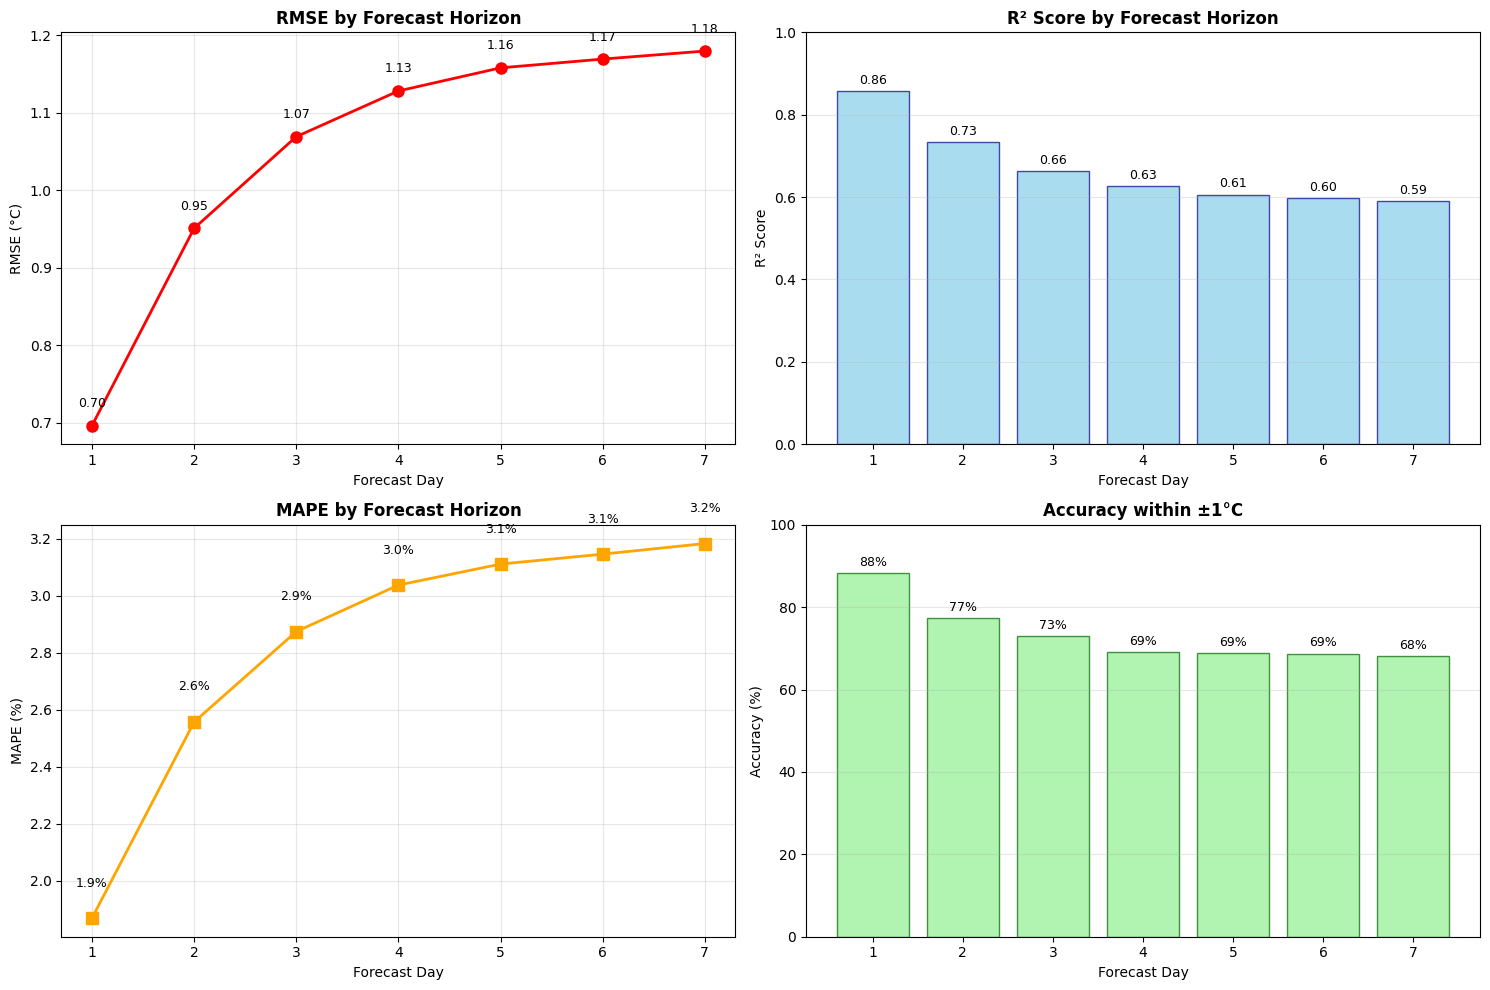

In [14]:
# Visual Performance Analysis
import matplotlib.pyplot as plt

# Create comprehensive performance visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. RMSE by forecast horizon
days = list(range(1, H+1))
rmse_by_day = [sqrt(mean_squared_error(Y_test.iloc[:, h], Y_pred[:, h])) for h in range(H)]

axes[0, 0].plot(days, rmse_by_day, marker='o', linewidth=2, markersize=8, color='red')
axes[0, 0].set_title('RMSE by Forecast Horizon', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Forecast Day')
axes[0, 0].set_ylabel('RMSE (°C)')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xticks(days)

# 2. R² Score by forecast horizon
axes[0, 1].bar(days, r2_scores, color='skyblue', alpha=0.7, edgecolor='navy')
axes[0, 1].set_title('R² Score by Forecast Horizon', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Forecast Day')
axes[0, 1].set_ylabel('R² Score')
axes[0, 1].grid(True, alpha=0.3, axis='y')
axes[0, 1].set_xticks(days)
axes[0, 1].set_ylim(0, 1)

# 3. MAPE by forecast horizon
axes[1, 0].plot(days, mape_scores, marker='s', linewidth=2, markersize=8, color='orange')
axes[1, 0].set_title('MAPE by Forecast Horizon', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Forecast Day')
axes[1, 0].set_ylabel('MAPE (%)')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_xticks(days)

# 4. Accuracy within 1°C tolerance
accuracy_1c = []
for h in range(H):
    actual = Y_test.iloc[:, h]
    predicted = Y_pred[:, h]
    within_tolerance = np.abs(actual - predicted) <= 1.0
    accuracy = (within_tolerance.sum() / len(actual)) * 100
    accuracy_1c.append(accuracy)

axes[1, 1].bar(days, accuracy_1c, color='lightgreen', alpha=0.7, edgecolor='darkgreen')
axes[1, 1].set_title('Accuracy within ±1°C', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Forecast Day')
axes[1, 1].set_ylabel('Accuracy (%)')
axes[1, 1].grid(True, alpha=0.3, axis='y')
axes[1, 1].set_xticks(days)
axes[1, 1].set_ylim(0, 100)

# Add performance values as text on bars/points
for i, (day, rmse) in enumerate(zip(days, rmse_by_day)):
    axes[0, 0].text(day, rmse + 0.02, f'{rmse:.2f}', ha='center', va='bottom', fontsize=9)

for i, (day, r2) in enumerate(zip(days, r2_scores)):
    axes[0, 1].text(day, r2 + 0.01, f'{r2:.2f}', ha='center', va='bottom', fontsize=9)

for i, (day, mape) in enumerate(zip(days, mape_scores)):
    axes[1, 0].text(day, mape + 0.1, f'{mape:.1f}%', ha='center', va='bottom', fontsize=9)

for i, (day, acc) in enumerate(zip(days, accuracy_1c)):
    axes[1, 1].text(day, acc + 1, f'{acc:.0f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

### Predict 7 days

In [15]:
X_last = df[selected_features].iloc[[-1]] # shape = (1, n_features)
t2m_next7 = model_lgbm.predict(X_last)[0]

# Get the last date in dataset and generate next 7 days
last_date = pd.to_datetime(df["date"].iloc[-1])
print(f"Last data date: {last_date.strftime('%Y-%m-%d (%A)')}")
print(f"Starting forecast from: {(last_date + pd.Timedelta(days=1)).strftime('%Y-%m-%d (%A)')}")
print()

# Generate forecast with dates
forecast_dates = [last_date + pd.Timedelta(days=i) for i in range(1, 8)]

for i, (date, temp) in enumerate(zip(forecast_dates, t2m_next7), start=1):
    day_name = date.strftime('%A')
    date_str = date.strftime('%Y-%m-%d')
    print(f"Day +{i}: {date_str} ({day_name}) → {temp:.2f}°C")

print(f"\nForecast Range: {t2m_next7.min():.2f}°C to {t2m_next7.max():.2f}°C")
print(f"Average Temperature: {t2m_next7.mean():.2f}°C")

# Temperature trend analysis
temp_trend = "increasing" if t2m_next7[-1] > t2m_next7[0] else "decreasing"
temp_change = abs(t2m_next7[-1] - t2m_next7[0])
print(f"7-day Trend: {temp_trend} ({temp_change:.2f}°C change)")

Last data date: 2025-11-10 (Monday)
Starting forecast from: 2025-11-11 (Tuesday)

Day +1: 2025-11-11 (Tuesday) → 27.48°C
Day +2: 2025-11-12 (Wednesday) → 27.16°C
Day +3: 2025-11-13 (Thursday) → 26.88°C
Day +4: 2025-11-14 (Friday) → 26.67°C
Day +5: 2025-11-15 (Saturday) → 26.52°C
Day +6: 2025-11-16 (Sunday) → 26.30°C
Day +7: 2025-11-17 (Monday) → 26.08°C

Forecast Range: 26.08°C to 27.48°C
Average Temperature: 26.73°C
7-day Trend: decreasing (1.40°C change)


### Pattern plot

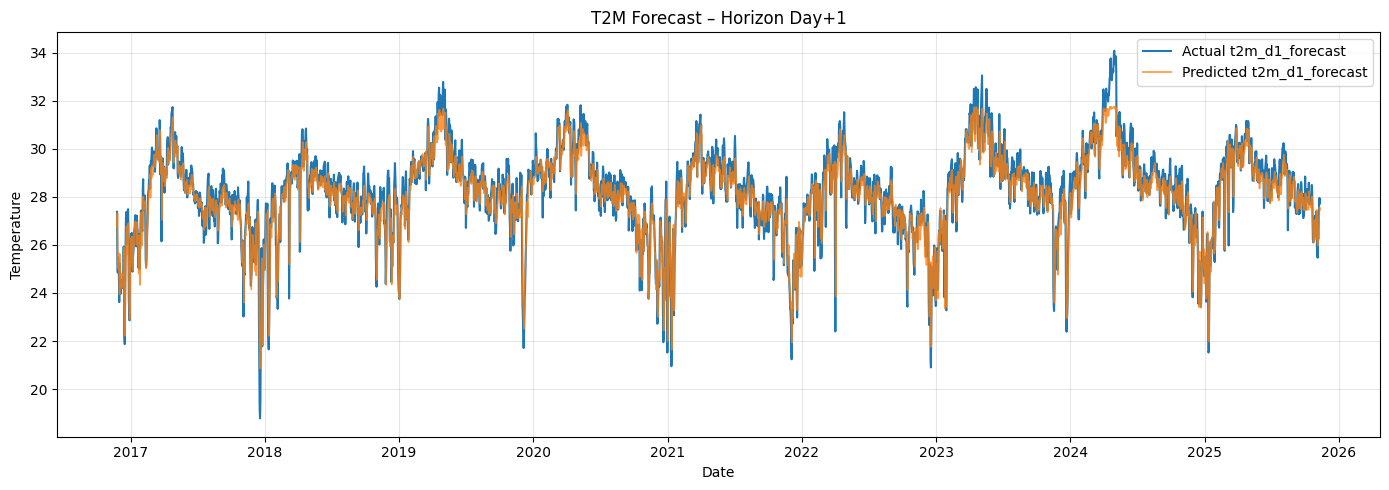

In [22]:
import matplotlib.pyplot as plt

# สร้าง date index สำหรับ test set
dates_test = pd.to_datetime(df["date"].iloc[split_idx:])

# เลือก horizon ที่อยากดู เช่น day+7 = index 6
h = 0   # 0 = day+1, 6 = day+7
target_name = t2m_targets[h]

plt.figure(figsize=(14, 5))
plt.plot(dates_test, Y_test.iloc[:, h], label=f"Actual {target_name}", linewidth=1.5)
plt.plot(dates_test, Y_pred[:, h], label=f"Predicted {target_name}", linewidth=1.2, alpha=0.8)

plt.title(f"T2M Forecast – Horizon Day+{h+1}")
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

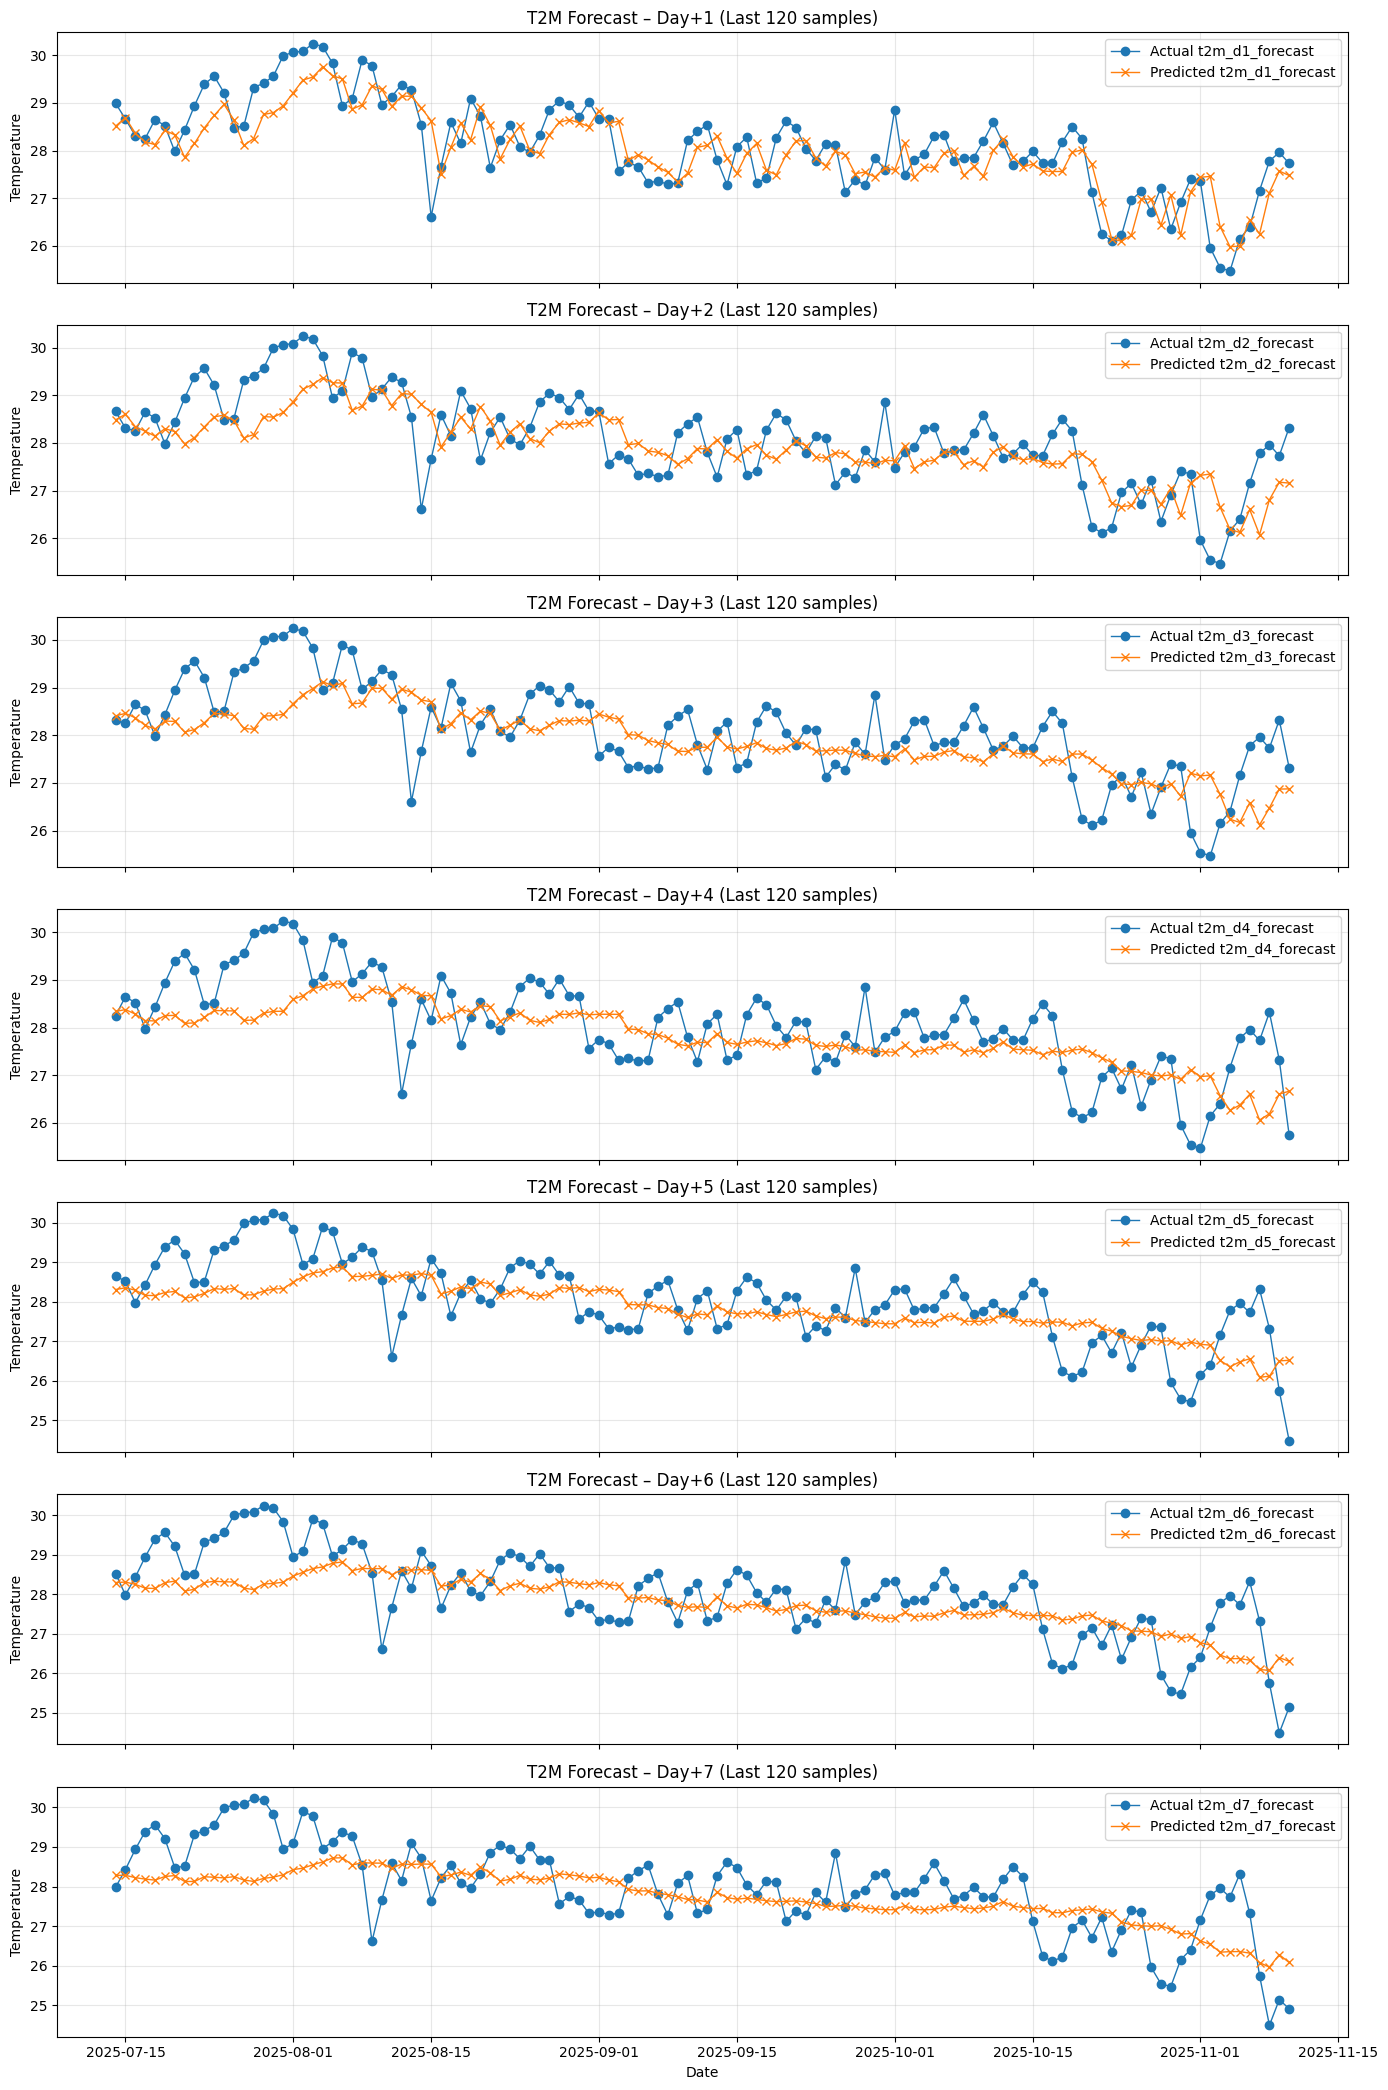

In [25]:
# จำนวนจุดที่อยาก zoom ดู
N = 120  # เช่น 4 เดือนสุดท้าย
days = [f"Day+{i+1}" for i in range(H)]
fig, axs = plt.subplots(H, 1, figsize=(14, 3*H), sharex=True)
for h in range(H):
    dates_zoom = dates_test[-N:]
    y_test_zoom = Y_test.iloc[-N:, h]
    y_pred_zoom = Y_pred[-N:, h]
    axs[h].plot(dates_zoom, y_test_zoom, label=f"Actual {t2m_targets[h]}", marker="o", linewidth=1)
    axs[h].plot(dates_zoom, y_pred_zoom, label=f"Predicted {t2m_targets[h]}", marker="x", linewidth=1)
    axs[h].set_title(f"T2M Forecast – {days[h]} (Last {N} samples)")
    axs[h].set_ylabel("Temperature")
    axs[h].legend()
    axs[h].grid(True, alpha=0.3)
plt.xlabel("Date")
plt.tight_layout()
plt.show()